<a href="https://colab.research.google.com/github/Rogerio-mack/fNIRS/blob/main/read_nirs_Fernanda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sumário

Captura e explora dados brutos de fNIRS no formato `.nirs`. 

Saídas:     

* Cria uma tabela de sumário dos canais
* Cria uma tabela de dos dados raw
* Cria uma tabela dos estímulos

<br>
<br>

<small>




# Mount Google Drive

Para acesso aos arquivos compartilhados. Tenha certeza de ter adicionado a pasta compartilhada ao seu Google Drive antes.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount('/content/drive', force_remount=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Common Imports

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import compress



# `.nirs`sub routines

In [4]:
#@markdown **def suboutines**
#@markdown ---
#@markdown * plotchannels(df, ncols_display=5, title='Display Channels') 
#@markdown > *plot raw data from each channel*
#@markdown * def remove_outlier(df_in, col_name)
#@markdown > *remove outliers from a single channel*

def plotchannels(df, ncols_display=3, title='Display Raw Channels'):
  nr_channels = len(df.columns)
  ncols= ncols_display
  nrows= int(nr_channels/ncols + 1)

  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, sharey=False, figsize=(ncols*5,nrows*3.5))

  i = 0
  for c in df.drop(columns=['time']):
    ax[i//ncols,i%ncols].plot(df.time, df[c], color=['blue','red'][df[c].min() < 0] )
    ax[i//ncols,i%ncols].set_title(c) # , weight='bold')
    # plt.xticks([])
    ax[i//ncols,i%ncols].grid()
    ax[i//ncols,i%ncols].set_xlabel('Time')
    i = i + 1
  
  plt.suptitle(title, fontsize=14, weight='bold', y=1.05)

  plt.tight_layout()
  plt.show()

  return

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out  

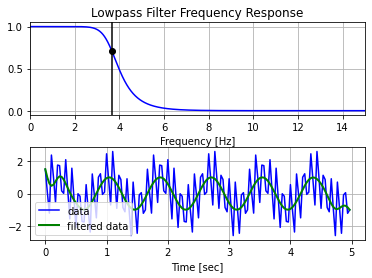


cutoff....  3.667
fs........  30.0
order.....  6



In [5]:
#@markdown **def suboutines**
#@markdown ---
#@markdown * def butter_lowpass_filter(data, cutoff, fs, order=5) 
#@markdown > *lowpass filter data from a single channel*


# https://stackoverflow.com/questions/25191620/
#   creating-lowpass-filter-in-scipy-understanding-methods-and-units

import numpy as np
from scipy.signal import butter, lfilter, freqz, filtfilt
from matplotlib import pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
#    y = lfilter(b, a, data)
    y = filtfilt(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = 5.0             # seconds
n = int(T * fs)     # total number of samples
t = np.linspace(0, T, n, endpoint=False)
# "Noisy" data.  We want to recover the 1.2 Hz signal from this.
data = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) \
        + 0.5*np.sin(12.0*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(t, data, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

print()
print('cutoff.... ', cutoff)
print('fs........ ', fs)
print('order..... ', order)
print()

In [6]:
# @markdown **def suboutines**
# @markdown ---
# @markdown * def df_filter(df, cutoff=0.8, fs=30, order=5, title='Filtered Data') 
# @markdown > *plot raw, cutted and filter data from each channel*

def df_filter(df, cutoff=0.8, fs=30, order=5, title='Filtered Data'): 

  nr_channels = len(df.columns)
  ncols= 3
  nrows= nr_channels

  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, sharey=False, figsize=(ncols*5,nrows*3.5))

  i = 0
  for c in df.drop(columns=['time']):
    y_cutted = remove_outlier(df,c)[c]
    y_filtered = butter_lowpass_filter(df[c], cutoff=cutoff, fs=fs, order=order)

    ax[i,0].plot(df.time, df[c], 'b-', label='raw data', alpha=0.8)
    ax[i,0].plot(df.time, y_filtered, 'r-', label='filtered data')
    ax[i,0].set_title('Channel ' + str(c) + ', Raw Data')
    ax[i,0].set_xlabel('Time')
    ax[i,0].grid()
    ax[i,0].legend()

    # ax[i,1].plot(df[c], 'b-', label='raw data')
    ax[i,1].plot(y_cutted, 'k-', label='cutted data', alpha=0.8)
    ax[i,1].set_title('Channel ' + str(c) + ', Cutted Data')
    ax[i,1].set_xlabel('Time')
    ax[i,1].grid()
    ax[i,1].legend()

    # ax[i,2].plot(df[c], 'b-', label='raw data')
    ax[i,2].plot(df.time, y_filtered, 'r-', label='filtered data', alpha=0.8)
    ax[i,2].set_title('Channel ' + str(c) + ', Filtered Data')
    ax[i,2].set_xlabel('Time')
    ax[i,2].grid()
    ax[i,2].legend()

    i=i+1

  plt.suptitle(title, fontsize=14, weight='bold', y=1.05)

  plt.tight_layout()
  plt.show()

  return  

# df_filter(raw[['time','S1_D1_685']], cutoff=0.8, fs=30, order=5, title='Filtered Data')  

In [7]:
#@markdown **`.nirs` sub routines**
#@markdown ---

import scipy.io

def load_nirs(path, mat_file):
  mat = scipy.io.loadmat(path + '/' + mat_file)
  return mat

def SD(name):
  sd = mat['SD'][0,0][list(mat['SD'][0].dtype.names).index(name)]
  return sd  

def create_channels(mat):
  channels = pd.DataFrame({'name':[], 
                          'source': [],
                          'detector': [],
                          'wavelength': [],
                          'source_pos': [],
                          'detector_pos': [],
                          'source_pos_3D': [],
                          'detector_pos_3D': []})

  for channel in SD('MeasList'):
    channel = channel.astype(int)
    c = pd.DataFrame({'name':[ 'S' + str(channel[0]) + '_D' + str(channel[1]) + '_' + str( int(SD('Lambda')[0][channel[3] - 1]) ) ], 
                      'source': [ int( channel[0] ) ],
                      'detector': [ int( channel[1] ) ],
                      'wavelength': [ int( SD('Lambda')[0][channel[3] - 1] ) ],
                      'source_pos': [ tuple(SD('SrcPos')[channel[0] - 1]) ],
                      'detector_pos': [ tuple(SD('DetPos')[channel[1] - 1]) ],
                      'source_pos_3D': [ tuple(SD('SrcPos3D')[channel[0] - 1]) ],
                      'detector_pos_3D': [ tuple(SD('DetPos3D')[channel[1] - 1]) ]})
    channels = pd.concat([channels,c]).reset_index(drop=True)

  channels['source'] = channels['source'].astype('int')
  channels['detector'] = channels['detector'].astype('int')
  channels['wavelength'] = channels['wavelength'].astype('int')
  
  return channels  

def create_raw(mat, channels):
  raw = pd.DataFrame({ 'time': mat['t'][:,0] })

  for i in range(mat['d'].shape[1]):
    raw[ channels['name'][i] ] = mat['d'][:,i]

  return raw   

def create_stimulus(mat):

  stimulus = pd.DataFrame({ 'time': mat['t'][:,0] })

  if 'CondNnames' not in mat.keys():
    print('...There is no CondNames for stimulus. Returning a empty stimulus')
    return stimulus

  if mat['s'].shape[1] != mat['CondNames'].shape[1]:
    print('...Error processing, stimulus, there are ', mat['s'].shape[1] ,
          's stimulus, but ', mat['CondNames'].shape[1], ' CondNames.')
    return -1

  for i in range(mat['CondNames'].shape[1]):
    stimulus[ mat['CondNames'][0][i][0] ] = mat['s'][:,i]

  return stimulus

def plot_stimulus(stimulus):
  plt.figure(figsize=(20,4))

  for c in stimulus.drop(columns=['time']):
    plt.plot(stimulus['time'],stimulus[c],label=c)

  plt.title('Stimulus', fontsize=14, weight='bold')  

  plt.legend()  
  plt.show()    

def namestr(obj, namespace=globals()):
    return [name for name in namespace if namespace[name] is obj][0]

# a = 'some var'
# namestr(a) 

def create_download_files(df, nirs_file, ext='.xlsx',path='/content/'):
  from google.colab import files
  
  if ext == '.xlsx':
    df.to_excel(path + nirs_file.split('.nirs')[0] + '_' + namestr(df) + ext)
  if ext == '.csv':  
    df.to_csv(path + nirs_file.split('.nirs')[0] + '_' + namestr(df) + ext)
   
  files.download(path + nirs_file.split('.nirs')[0] + '_' + namestr(df) + ext)

  print('Downloading... ' + path + nirs_file.split('.nirs')[0] + '_' + namestr(df) + ext)
  return


# Load `.nirs` data set

# Carregando **Um Único Sujeito**

In [8]:
path = '/content/drive/MyDrive/coletas IC TCC'
file = 'JMVR_TCC_13.nirs'

mat = load_nirs(path, file)

mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'brainsight', 'ml', 'd', 't', 's', 'aux', 'SD'])

In [9]:
entry = file
mat = load_nirs(path, entry)
channels = create_channels(mat)
raw = create_raw(mat, channels)
stimulus = create_stimulus(mat)

...There is no CondNames for stimulus. Returning a empty stimulus


## channels

In [10]:
channels

,name,source,detector,wavelength,source_pos,detector_pos,source_pos_3D,detector_pos_3D
0,S1_D2_685,1,2,685,"(-0.7177395805664506, -0.3006517735028356, 0.0...","(-0.8075278663086177, -0.464111943216596, -0.1...","(-7.333440508380804, 1.1512473990823282, 4.449...","(-8.204087786127747, 0.004823804377237196, 2.0..."
1,S1_D2_830,1,2,830,"(-0.7177395805664506, -0.3006517735028356, 0.0...","(-0.8075278663086177, -0.464111943216596, -0.1...","(-7.333440508380804, 1.1512473990823282, 4.449...","(-8.204087786127747, 0.004823804377237196, 2.0..."
2,S1_D3_685,1,3,685,"(-0.7177395805664506, -0.3006517735028356, 0.0...","(-0.5232160911886442, -0.11550025553225624, 0....","(-7.333440508380804, 1.1512473990823282, 4.449...","(-5.380902488038188, 2.5806802073728363, 6.346..."
3,S1_D3_830,1,3,830,"(-0.7177395805664506, -0.3006517735028356, 0.0...","(-0.5232160911886442, -0.11550025553225624, 0....","(-7.333440508380804, 1.1512473990823282, 4.449...","(-5.380902488038188, 2.5806802073728363, 6.346..."
4,S1_D4_685,1,4,685,"(-0.7177395805664506, -0.3006517735028356, 0.0...","(-0.6071952391178613, 0.007952377826939572, -0...","(-7.333440508380804, 1.1512473990823282, 4.449...","(-6.040828498439194, 4.395722296150654, 3.7)"
5,S1_D4_830,1,4,830,"(-0.7177395805664506, -0.3006517735028356, 0.0...","(-0.6071952391178613, 0.007952377826939572, -0...","(-7.333440508380804, 1.1512473990823282, 4.449...","(-6.040828498439194, 4.395722296150654, 3.7)"
6,S1_D12_685,1,12,685,"(-0.7177395805664506, -0.3006517735028356, 0.0...","(-0.7196784121825031, -0.17491423655053856, -0...","(-7.333440508380804, 1.1512473990823282, 4.449...","(-7.22436664219691, 2.723438590336899, 2.97656..."
7,S1_D12_830,1,12,830,"(-0.7177395805664506, -0.3006517735028356, 0.0...","(-0.7196784121825031, -0.17491423655053856, -0...","(-7.333440508380804, 1.1512473990823282, 4.449...","(-7.22436664219691, 2.723438590336899, 2.97656..."
8,S2_D1_685,2,1,685,"(-0.345545502830686, 0.20046859945023032, 0.08...","(-0.017854301845853775, 0.35026389970456473, 0...","(-3.4097967870749333, 5.888430026647747, 5.513...","(-0.050378089285470655, 7.314221455921277, 5.3..."
9,S2_D1_830,2,1,830,"(-0.345545502830686, 0.20046859945023032, 0.08...","(-0.017854301845853775, 0.35026389970456473, 0...","(-3.4097967870749333, 5.888430026647747, 5.513...","(-0.050378089285470655, 7.314221455921277, 5.3..."


## Raws

In [11]:
raw.head()

,time,S1_D2_685,S1_D2_830,S1_D3_685,S1_D3_830,S1_D4_685,S1_D4_830,S1_D12_685,S1_D12_830,S2_D1_685,S2_D1_830,S2_D4_685,S2_D4_830,S2_D5_685,S2_D5_830,S2_D13_685,S2_D13_830,S3_D10_685,S3_D10_830,S3_D6_685,S3_D6_830,S3_D7_685,S3_D7_830,S3_D8_685,S3_D8_830,S4_D1_685,S4_D1_830,S4_D11_685,S4_D11_830,S4_D8_685,S4_D8_830,S4_D9_685,S4_D9_830
0,0.0,2898.707520,33064.507812,997.506775,12710.771484,1857.591431,22010.710938,137.819351,1252.922485,49.169315,1625.446533,906.044617,9447.477539,10638.677734,61355.703125,100.017975,764.460144,14.463219,99.911171,164.634918,3311.316895,-117.601723,27.702578,75.978493,-90.816154,260.606171,740.190674,3.236514,36.842468,36.592438,-96.163078,3345.128418,38608.414062
1,0.1,3040.588379,32420.701172,981.534546,12499.233398,1692.960205,21326.148438,125.217163,1248.020874,112.441216,1742.606812,1088.698364,9156.497070,10531.000977,60210.664062,107.521591,776.148560,10.696359,114.224556,310.812805,3164.913086,-187.360031,202.861130,-132.297958,107.781578,218.274704,606.959717,1.485319,27.219101,6.793223,136.612793,2958.985107,35604.906250
2,0.2,3219.327393,32788.238281,798.234314,12588.352539,1875.380127,21556.851562,137.394592,1259.567627,116.224159,1830.991699,786.552307,9137.006836,10665.501953,60665.832031,97.796707,786.487671,13.086955,116.994301,180.227051,3243.378906,-40.851181,23.178547,111.373390,-46.903206,-55.888870,519.334290,1.228658,27.958254,115.679771,-67.184479,2876.920166,36194.656250
3,0.3,3361.630615,32739.605469,1024.880859,12494.580078,1609.956299,21808.996094,134.967422,1257.121094,-31.313965,1746.989746,857.147034,9239.918945,10578.481445,60790.691406,98.989006,788.271606,4.034494,114.436119,98.864983,3161.132080,-71.836334,22.245697,-3.990156,-62.858196,129.249619,599.026245,-3.419914,31.036943,-16.447556,64.276497,2973.742188,36297.988281
4,0.4,2972.378174,32754.945312,743.263916,12451.780273,1814.879272,21470.937500,134.718323,1255.567749,40.043659,1933.065186,1078.886597,9292.744141,10597.536133,60680.667969,100.075844,788.829407,18.998680,116.840828,162.100113,3262.859131,93.410683,107.557587,-7.050020,-0.205143,88.512001,558.063477,2.448276,26.748999,-19.540363,-60.148937,2949.194336,36177.441406


## Stimulus

...There is no CondNames for stimulus. Returning a empty stimulus


No handles with labels found to put in legend.


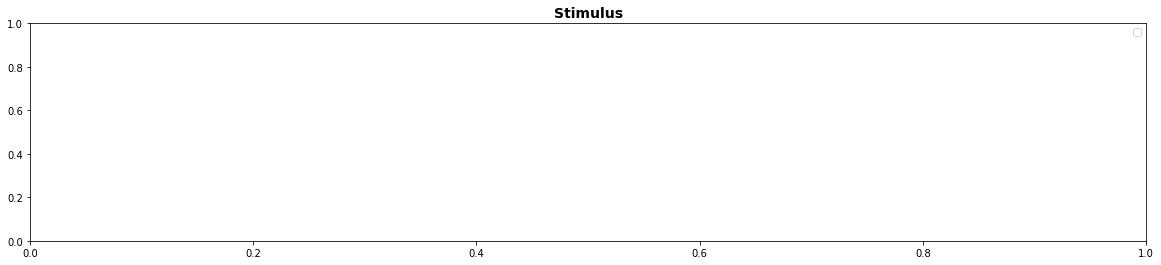

,time
0,0.0
1,0.1
2,0.2
3,0.3
4,0.4


In [12]:
stimulus = create_stimulus(mat)

plot_stimulus(stimulus)
stimulus.head()

## Download to `.xlsx` files

In [13]:

# Descomentar para download dos arquivos...

# create_download_files(channels, file)  
# create_download_files(raw, file)  
# create_download_files(stimulus, file)  


# Carregando **Todos Sujeitos**

In [14]:
import os

path = '/content/drive/MyDrive/coletas IC TCC'

all_nirs = {}

for entry in os.listdir(path):
  if os.path.isfile(os.path.join(path, entry)):
    if entry.find('.nirs') > 0:
      print()
      print('Processing... ', entry)

      mat = load_nirs(path, entry)
      channels = create_channels(mat)
      raw = create_raw(mat, channels)
      stimulus = create_stimulus(mat)

      all_nirs[ entry.split('.nirs')[0] ] = {'channels':channels,
                                             'raw':raw,
                                             'stimulus':stimulus}




Processing...  JMVR_TCC_17.nirs
...There is no CondNames for stimulus. Returning a empty stimulus

Processing...  JMVR_TCC_18.nirs
...There is no CondNames for stimulus. Returning a empty stimulus

Processing...  JMVR_TCC_19.nirs
...There is no CondNames for stimulus. Returning a empty stimulus

Processing...  JMVR_TCC_20.nirs
...There is no CondNames for stimulus. Returning a empty stimulus

Processing...  JMVR_TCC_21.nirs
...There is no CondNames for stimulus. Returning a empty stimulus

Processing...  JMVR_TCC_22.nirs
...There is no CondNames for stimulus. Returning a empty stimulus

Processing...  JMVR_TCC_23.nirs
...There is no CondNames for stimulus. Returning a empty stimulus

Processing...  JMVR_TCC_13.nirs
...There is no CondNames for stimulus. Returning a empty stimulus

Processing...  JMVR_TCC_14.nirs
...There is no CondNames for stimulus. Returning a empty stimulus

Processing...  JMVR_TCC_15.nirs
...There is no CondNames for stimulus. Returning a empty stimulus

Processin

In [15]:
all_nirs.keys()

dict_keys(['JMVR_TCC_17', 'JMVR_TCC_18', 'JMVR_TCC_19', 'JMVR_TCC_20', 'JMVR_TCC_21', 'JMVR_TCC_22', 'JMVR_TCC_23', 'JMVR_TCC_13', 'JMVR_TCC_14', 'JMVR_TCC_15', 'JMVR_TCC_16'])

In [16]:
first = True

for nirs, data in all_nirs.items():
  # print(nirs, data)
  raw_sign_Series = data['raw'].drop(columns='time').min() > 0
  df_raw_sign = raw_sign_Series.to_frame(name='value').T
  df_raw_sign.index=[nirs]
  if first:
    raw_sign = df_raw_sign.copy()
    first = False
  else:
    if df_raw_sign.shape[1] == raw_sign.shape[1]:
      raw_sign = pd.concat([ raw_sign, df_raw_sign ])
    else:
      print('...Error, first nirs has ', raw_sign.shape[1], ' channels ', nirs , ' has ', df_raw_sign.shape[1], ' instead.')    
  # break 
raw_sign

,S1_D2_685,S1_D2_830,S1_D3_685,S1_D3_830,S1_D4_685,S1_D4_830,S1_D12_685,S1_D12_830,S2_D1_685,S2_D1_830,S2_D4_685,S2_D4_830,S2_D5_685,S2_D5_830,S2_D13_685,S2_D13_830,S3_D10_685,S3_D10_830,S3_D6_685,S3_D6_830,S3_D7_685,S3_D7_830,S3_D8_685,S3_D8_830,S4_D1_685,S4_D1_830,S4_D11_685,S4_D11_830,S4_D8_685,S4_D8_830,S4_D9_685,S4_D9_830
JMVR_TCC_17,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
JMVR_TCC_18,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
JMVR_TCC_19,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False
JMVR_TCC_20,True,True,False,True,False,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
JMVR_TCC_21,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False
JMVR_TCC_22,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True
JMVR_TCC_23,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
JMVR_TCC_13,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,False,True,False,True,False,False,False,False,False,False,False,True,False,False,True,True
JMVR_TCC_14,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
JMVR_TCC_15,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False


# **Channels $\times$ Sujeitos**

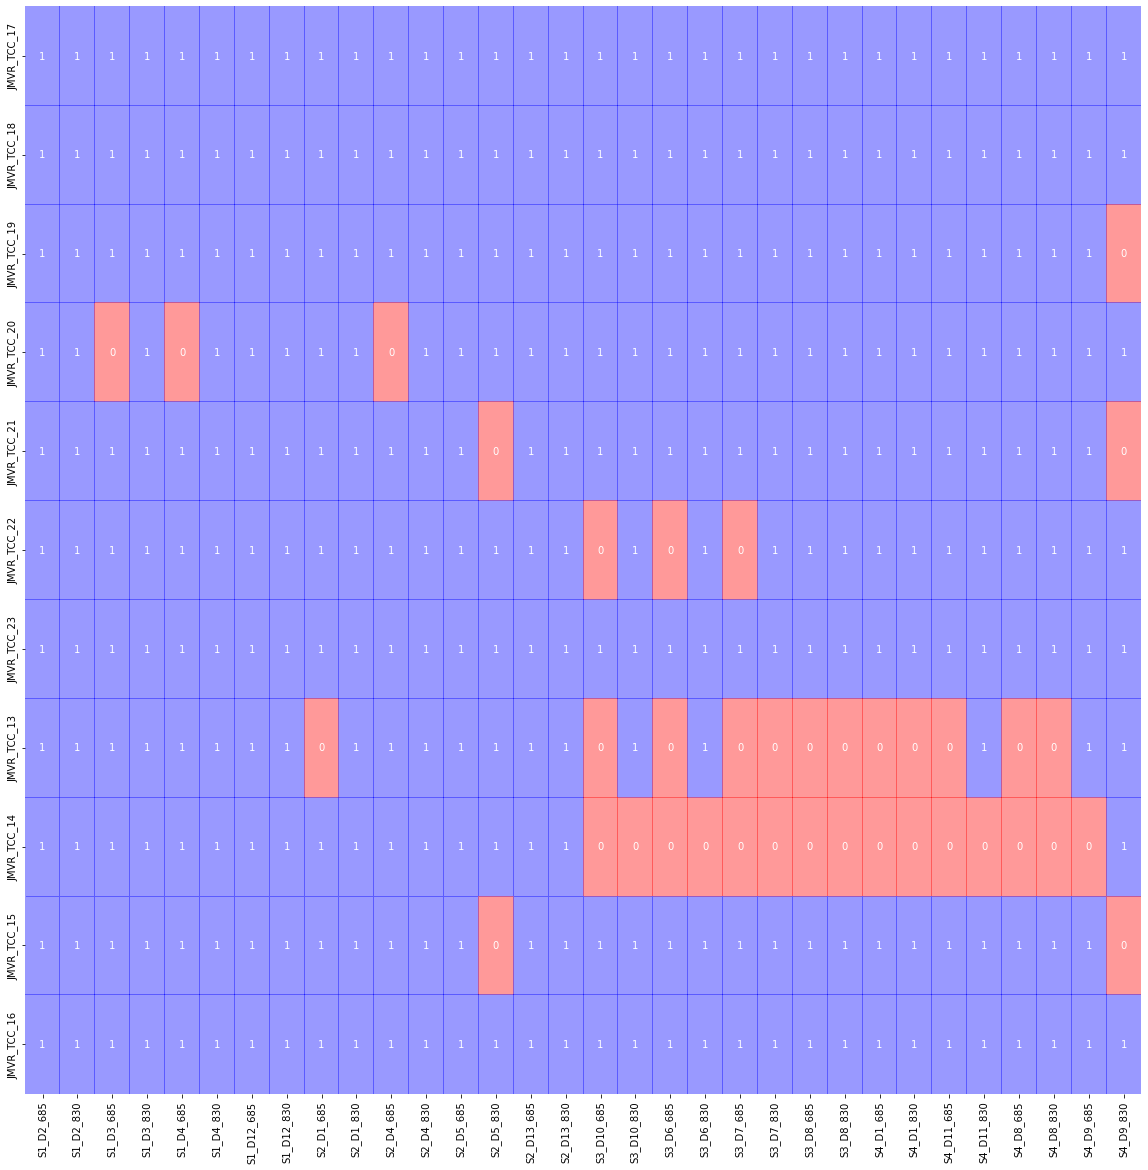

In [17]:
plt.figure(figsize=(20,20))
import matplotlib.cm as cm

sns.heatmap(raw_sign,annot=True,cbar=False,cmap=cm.bwr_r,alpha=0.4)
plt.show()

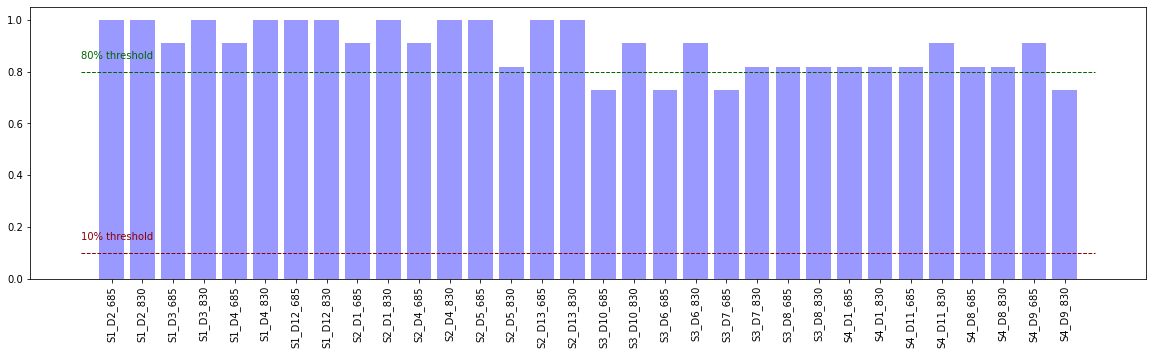

In [18]:
plt.figure(figsize=(20,5))
import matplotlib.cm as cm

raw_sign_summary = raw_sign.sum() / len(raw_sign)
plt.bar(raw_sign_summary.index,raw_sign_summary,color=cm.bwr_r(1.0),alpha=0.4)
plt.xticks(rotation=90)
plt.hlines(0.1,0-1,len(raw_sign_summary),linestyles='dashed',lw=1,color='Darkred')
plt.text(0-1,0.15,'10% threshold',color='Darkred')
plt.hlines(0.80,0-1,len(raw_sign_summary),linestyles='dashed',lw=1,color='Darkgreen')
plt.text(0-1,0.85,'80% threshold',color='Darkgreen')
plt.show()

# **RAW de todos os Canais de Um Sujeito**

## Exemplo de um Sujeito com boas coletas na maior parte dos canais

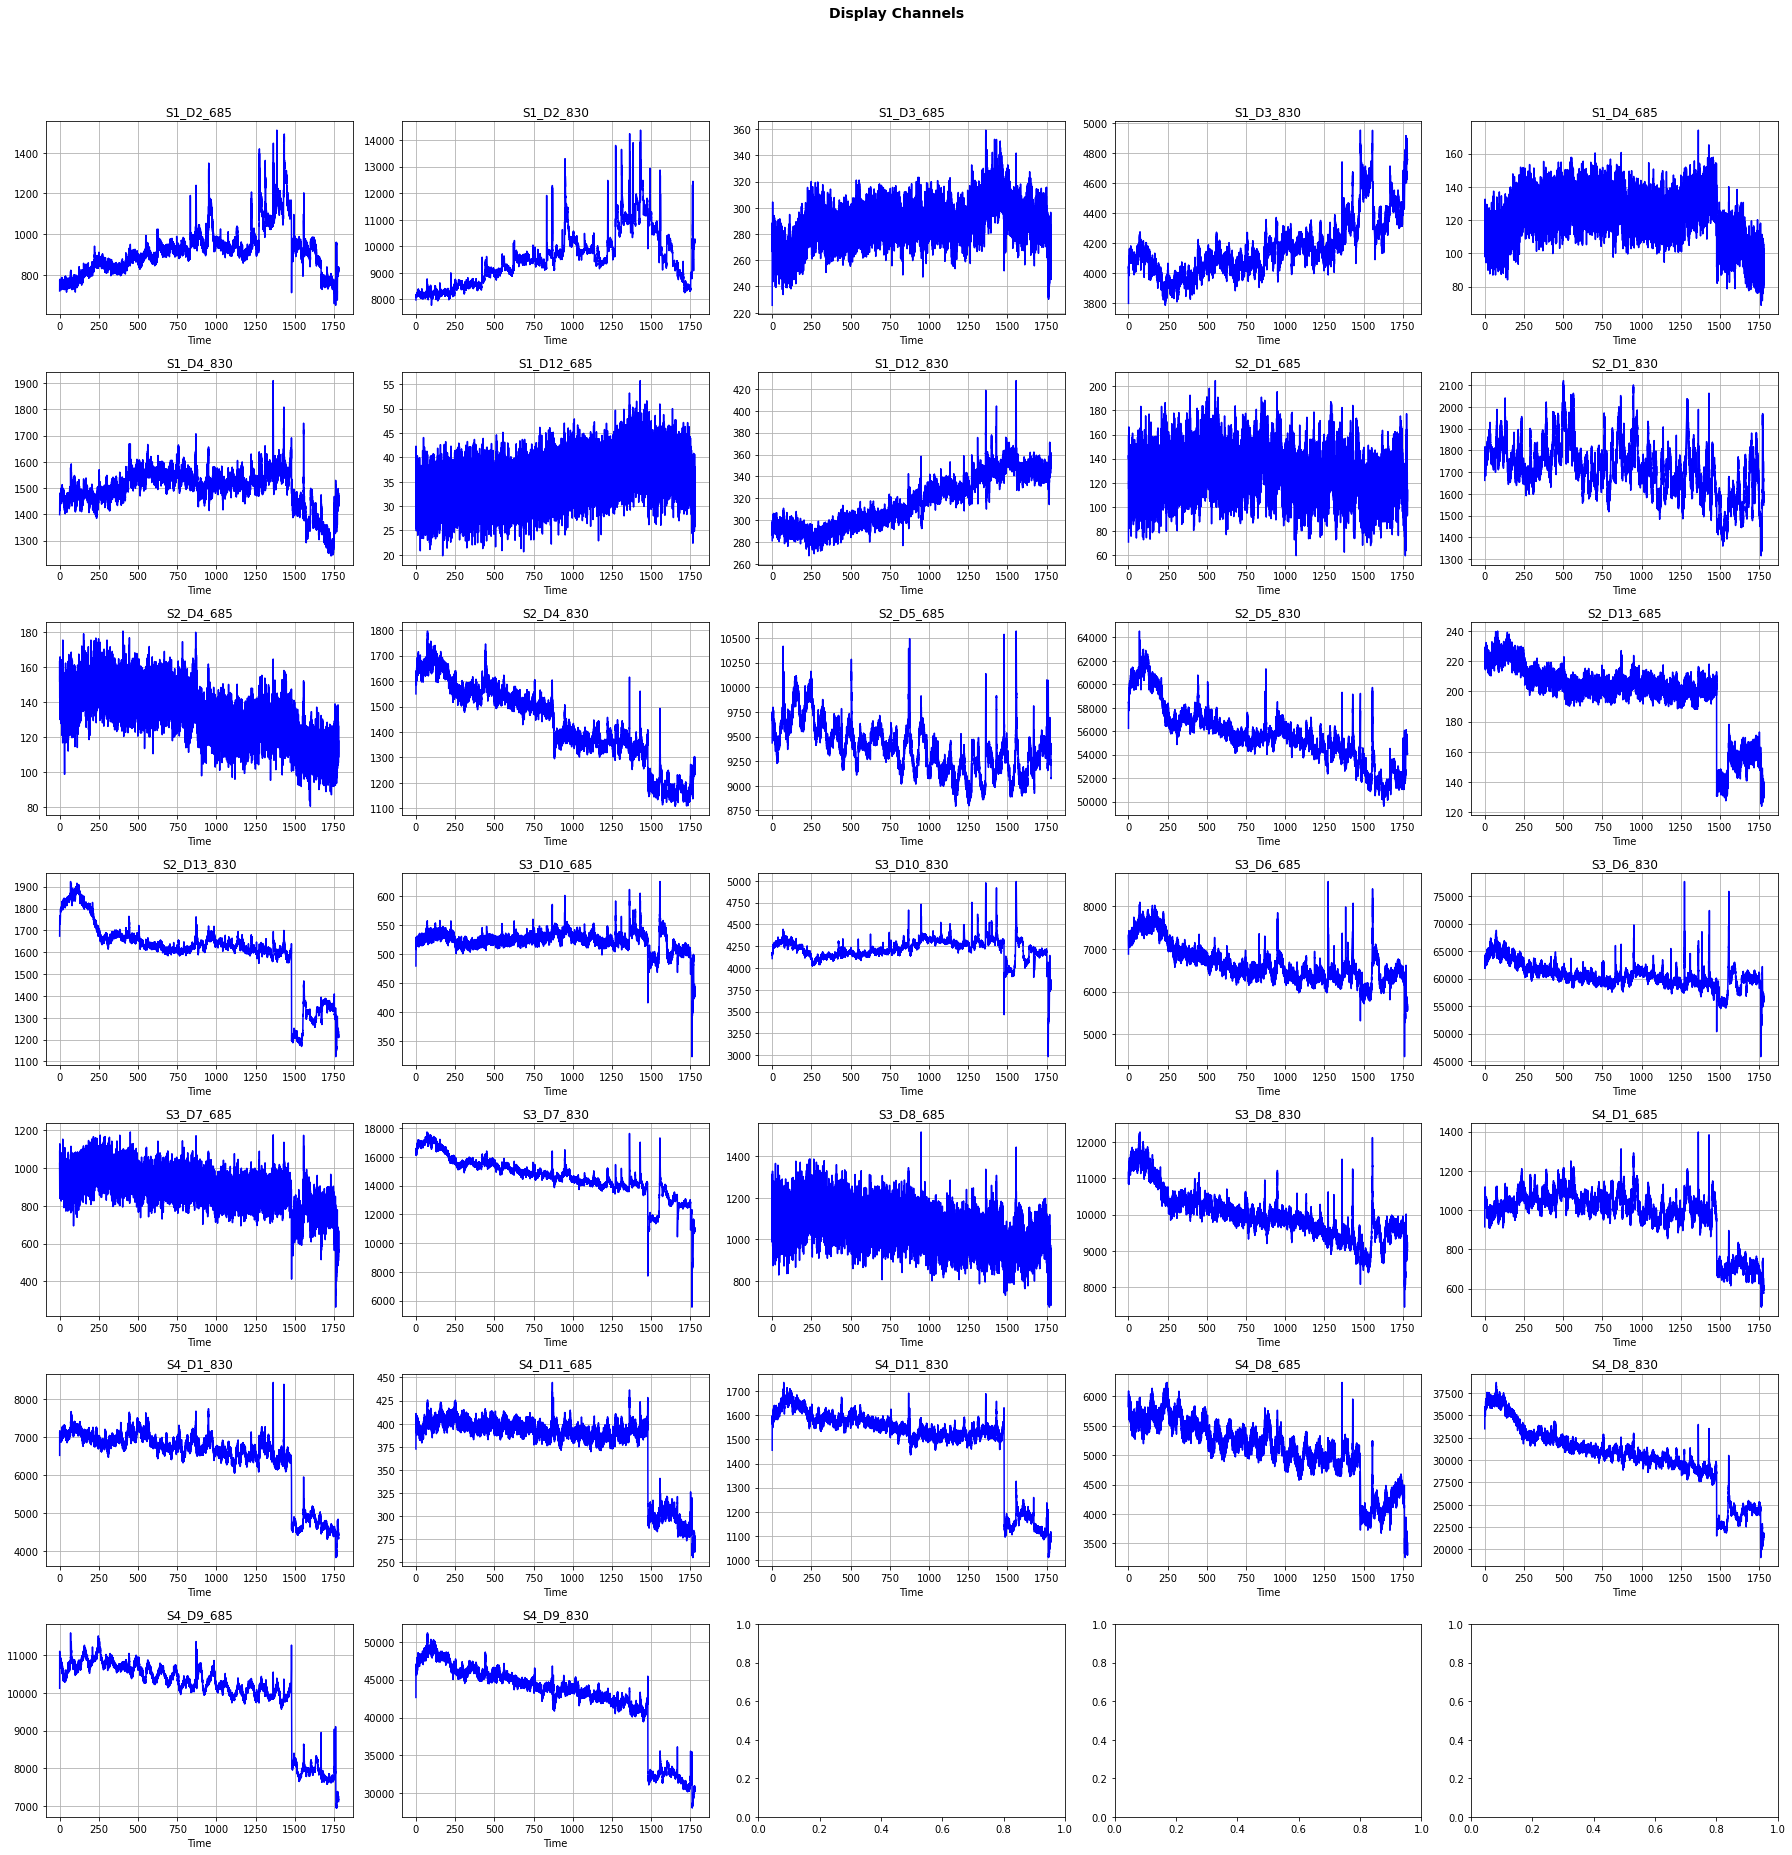

In [19]:
plotchannels(all_nirs['JMVR_TCC_16']['raw'], ncols_display=5, title='Display Channels')

## Exemplo de um Sujeito com más coletas em um grande número de canais

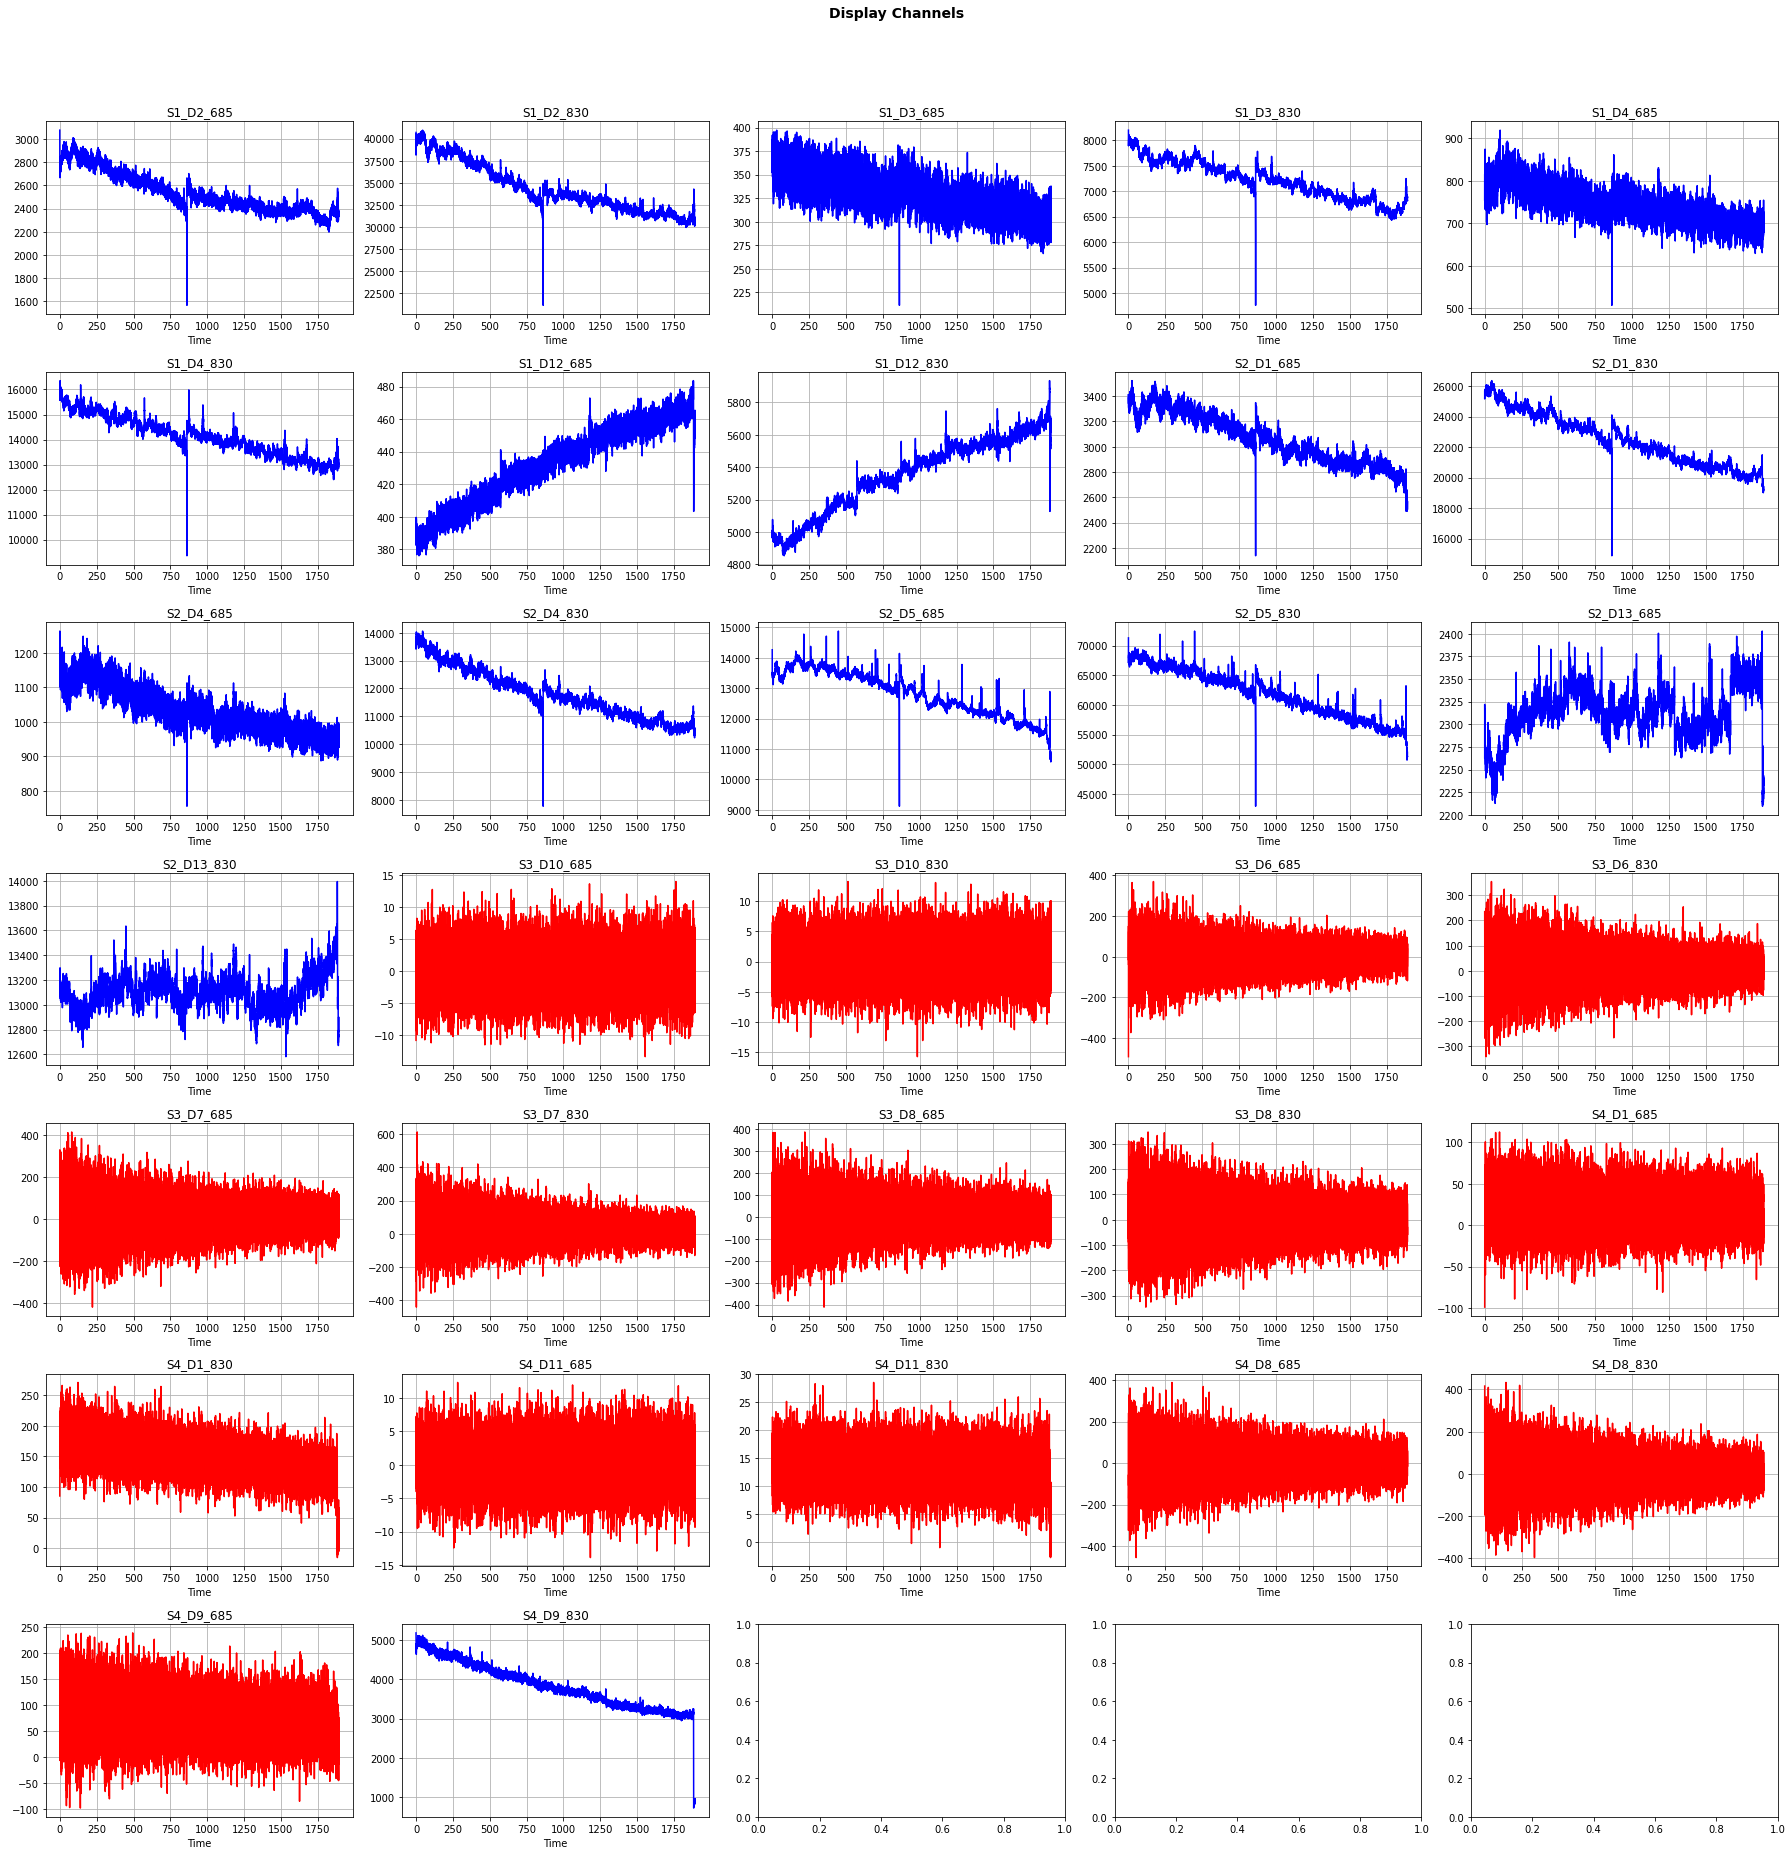

In [20]:
plotchannels(all_nirs['JMVR_TCC_14']['raw'], ncols_display=5, title='Display Channels')

## Plot somente dos canais ruins (contendo valores $<0$)

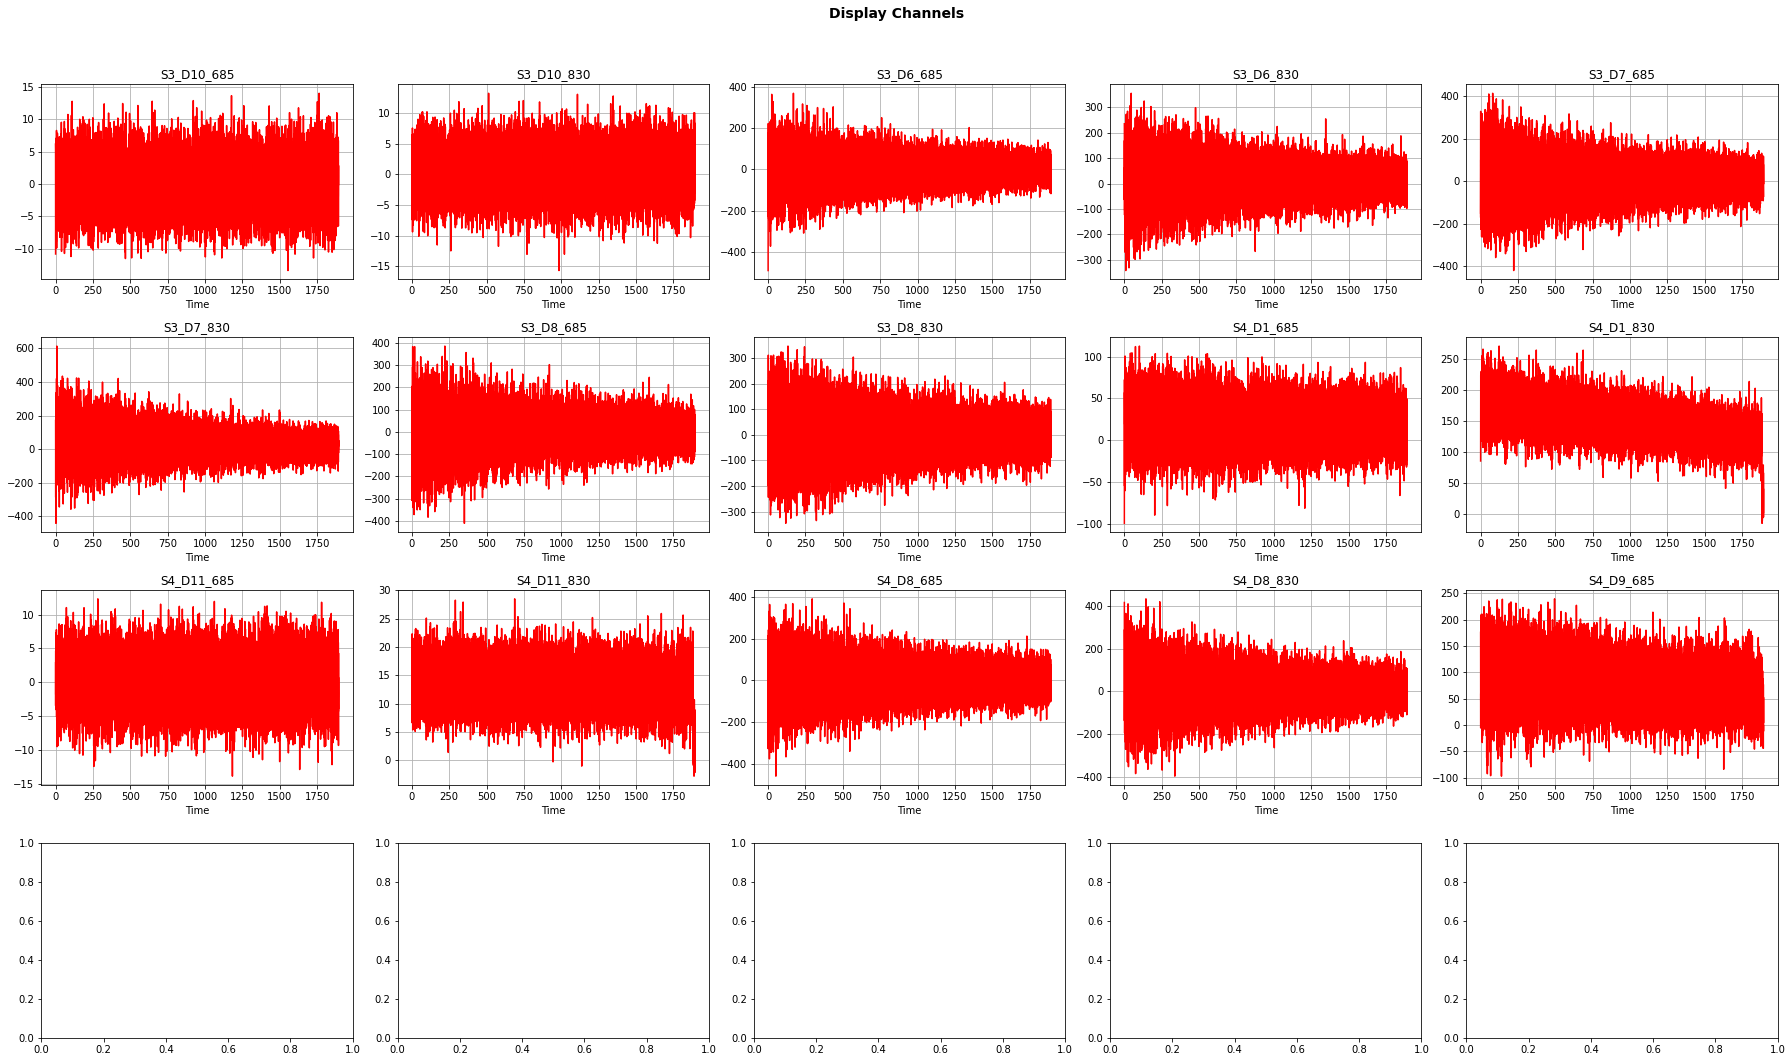

In [21]:
df = all_nirs['JMVR_TCC_14']['raw'].copy()
df_red = df[[ c for c in df if df[c].min() < 0 ]].copy()
df_red['time'] = df['time'] 

plotchannels(df_red, ncols_display=5, title='Display Channels')

# Formato `.nirs`

*Fonte: [Homer2_UserGuide](https://www.nmr.mgh.harvard.edu/martinos/software/homer/HOMER2_UsersGuide_121129.pdf)*

<br>

`t` - This variable is the data time points array. It contains the data acquisition times. The dimensions of this array
are <number of time points> by 1.

`d` - This variable is the raw intensity time course. It is a 2D array where each element in row i, column j contains
the raw intensity at time point i, in channel j. The dimensions of this array are <number of time points> by
<number of measurement channels>

`SD` - This is a structured variable containing the source/detector geometry. It has the following fields:

> `Lambda` - Wavelengths used for data acquisition; dimensions <number of wavelengths> by 1

> `nSrcs` - Number of lasers; scalar variable

> `nDets`- Number of detectors; scalar variable

> `SrcPos` - Array of probe coordinates of the lasers; dimensions <number of lasers> by 3

> `DetPos` - Array of probe coordinates of the detectors; dimensions <number of detectors> by 3

> `MeasList` - List of source/detector/wavelength measurement channels. It’s an array with dimensions, <number of channels> by 4. The meaning of the 4 columns are as follows:

>> Column 1 index of the source from the SD.SrcPos list.

>>  Column 2 index of the detector from the SD.DetPos list.

>>  Column 3 is unused right now and contains all ones.

>>  Column 4 index of the wavelength from SD.Lambda.

`s` - This variable specifies the time points and condition of stimulus onsets. Conditions are a way to separate
stimuli into different groups, where each group is averaged independently of stimuli belonging to other
conditions. Initially the values in s are binary; 1 at time point i designating stimulus onset, 0 designating no
stimulus at time point i. The dimensions of s are <number of time points> by <number of
conditions>.

`ml` - List of source-detector channels. This is a duplicate of the SD.MeasList above.

`aux` - auxiliary signal of same dimensions as t. 

`CondNames` - a list of condition names used for the stimulus marks 

`tIncMan` -  Manual time exclusion
 
`SD.MeasListAct` - Manual channel pruning 

`s0` - The s matrix is modified as a result of stimulus mark exclusion, deletion or addition of new stimulus marks. If the s matrix is changed in any way, the original s matrix is saved in s0. 

The following additional parameters will be saved in the .nirs files as a result of data processing: 

`procInput` - This variable contains the processing stream functions, their parameters and values used to process data.

`procResult` - Contains the results of processing including optical density, concentration, optical density and concentration averages, and any other variables that are the  result of executing the processing stream.  



In [22]:
path = '/content/drive/MyDrive/fNIRS - análises compartilhadas/5. Dados de Finger Tapping 2'
file = 'ana.nirs'

mat = load_nirs(path, file)

mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'CondNames', 'ans', 'aux', 'brainsight', 'd', 'ml', 's0', 't', 'procInput', 'userdata', 'procResult', 'SD', 's', 'tIncMan'])

`t` - This variable is the data time points array. It contains the data acquisition times. The dimensions of this array
are <number of time points> by 1.

In [23]:
print( mat['t'].shape, '\n\n', mat['t'] )

(12201, 1) 

 [[0.00000000e+00]
 [1.00000001e-01]
 [2.00000003e-01]
 ...
 [1.21980005e+03]
 [1.21990002e+03]
 [1.22000000e+03]]


`d` - This variable is the raw intensity time course. It is a 2D array where each element in row i, column j contains
the raw intensity at time point i, in channel j. The dimensions of this array are <number of time points> by
<number of measurement channels>

In [24]:
print( mat['d'].shape, '\n\n', mat['d'] )

(12201, 40) 

 [[-1.61307883e+00 -4.41529036e+00 -1.69386733e+00 ...  3.25636780e+02
   5.13639221e+01  6.59777161e+02]
 [ 2.01356554e+00  8.73393416e-01  4.70728302e+00 ...  4.10270508e+02
   6.79504547e+01  7.23516785e+02]
 [ 4.58463371e-01  4.81897879e+00  2.33773515e-01 ...  4.16588898e+02
   6.71219482e+01  7.36304688e+02]
 ...
 [-4.74421787e+00  1.09265268e+00  5.91088438e+00 ...  4.02792938e+02
   6.12438164e+01  7.55697144e+02]
 [ 1.08703482e+00 -4.47931910e+00 -1.38947582e+00 ...  4.01285797e+02
   6.06569672e+01  7.53893188e+02]
 [-1.26406562e+00  4.05041027e+00  5.25978374e+00 ...  3.97015106e+02
   6.08106537e+01  7.48290710e+02]]


`SD` - This is a structured variable containing the source/detector geometry. It has the following fields:

> `Lambda` - Wavelengths used for data acquisition; dimensions <number of wavelengths> by 1

> `nSrcs` - Number of lasers; scalar variable

> `nDets`- Number of detectors; scalar variable

> `SrcPos` - Array of probe coordinates of the lasers; dimensions <number of lasers> by 3

> `DetPos` - Array of probe coordinates of the detectors; dimensions <number of detectors> by 3

> `MeasList` - List of source/detector/wavelength measurement channels. It’s an array with dimensions, <number of channels> by 4. The meaning of the 4 columns are as follows:

>> Column 1 index of the source from the SD.SrcPos list.

>>  Column 2 index of the detector from the SD.DetPos list.

>>  Column 3 is unused right now and contains all ones.

>>  Column 4 index of the wavelength from SD.Lambda.

In [25]:
print( mat['SD'][0].dtype.names )

('Lambda', 'nSrcs', 'nDets', 'SrcPos3D', 'SrcPos', 'DetPos3D', 'DetPos', 'MeasList', 'SpatialUnit', 'xmin', 'xmax', 'ymin', 'ymax', 'MeasListAct', 'MeasListVis')


In [26]:
def SD(name):
  sd = mat['SD'][0,0][list(mat['SD'][0].dtype.names).index(name)]
  return sd  

In [27]:
print('lambda: ', SD('Lambda')[0])

lambda:  [685 830]


In [28]:
print('nSrcs: ', SD('nSrcs')[0], 'nDets: ', SD('nDets')[0])

nSrcs:  [5] nDets:  [15]


In [29]:
print('SrcPos: \n', SD('SrcPos'), '\n\n',  'DetPos: \n', SD('DetPos'))

SrcPos: 
 [[ 6.   0.   0. ]
 [ 6.   6.   0. ]
 [13.5  6.   0. ]
 [ 3.   3.   0. ]
 [13.5  3.   0. ]] 

 DetPos: 
 [[ 9.   0.   0. ]
 [ 8.5  4.5  0. ]
 [ 8.5  7.5  0. ]
 [13.5  0.   0. ]
 [13.5  3.   0. ]
 [16.5  3.   0. ]
 [15.5  0.   0. ]
 [ 6.   3.   0. ]
 [ 6.   9.   0. ]
 [ 3.   6.   0. ]
 [15.   8.5  0. ]
 [16.5  6.   0. ]
 [ 3.   0.   0. ]
 [ 0.   3.   0. ]
 [10.5  3.   0. ]]


In [30]:
print('MeasList shape: \n', SD('MeasList').shape, '\n\n', 'MeasList: \n', SD('MeasList'))

MeasList shape: 
 (40, 4) 

 MeasList: 
 [[ 1  1  1  1]
 [ 1  1  1  2]
 [ 1  8  1  1]
 [ 1  8  1  2]
 [ 1 13  1  1]
 [ 1 13  1  2]
 [ 2  2  1  1]
 [ 2  2  1  2]
 [ 2  3  1  1]
 [ 2  3  1  2]
 [ 2  8  1  1]
 [ 2  8  1  2]
 [ 2  9  1  1]
 [ 2  9  1  2]
 [ 2 10  1  1]
 [ 2 10  1  2]
 [ 3  5  1  1]
 [ 3  5  1  2]
 [ 3  6  1  1]
 [ 3  6  1  2]
 [ 3 11  1  1]
 [ 3 11  1  2]
 [ 3 12  1  1]
 [ 3 12  1  2]
 [ 4  8  1  1]
 [ 4  8  1  2]
 [ 4 13  1  1]
 [ 4 13  1  2]
 [ 4 14  1  1]
 [ 4 14  1  2]
 [ 5  4  1  1]
 [ 5  4  1  2]
 [ 5  5  1  1]
 [ 5  5  1  2]
 [ 5  6  1  1]
 [ 5  6  1  2]
 [ 5  7  1  1]
 [ 5  7  1  2]
 [ 5 15  1  1]
 [ 5 15  1  2]]


`s` - This variable specifies the time points and condition of stimulus onsets. Conditions are a way to separate
stimuli into different groups, where each group is averaged independently of stimuli belonging to other
conditions. Initially the values in s are binary; 1 at time point i designating stimulus onset, 0 designating no
stimulus at time point i. The dimensions of s are <number of time points> by <number of
conditions>.

In [31]:
mat['s']

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

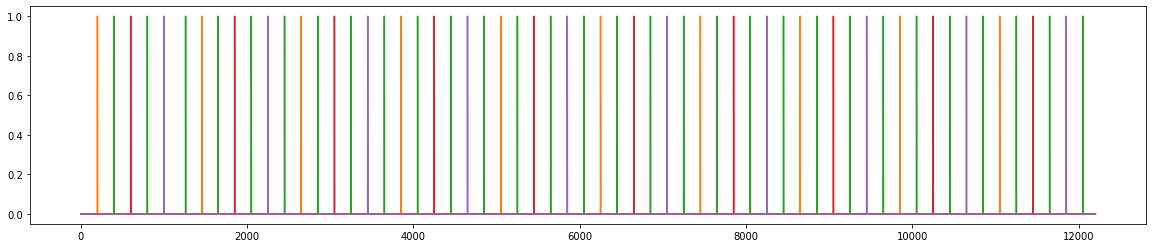

In [32]:
plt.figure(figsize=(20,4))
plt.plot(mat['s'])
plt.show()

In [33]:
mat['CondNames'][0]

array([array(['1'], dtype='<U1'), array(['MD'], dtype='<U2'),
       array(['REST'], dtype='<U4'), array(['ME'], dtype='<U2'),
       array(['MD_ME'], dtype='<U5')], dtype=object)

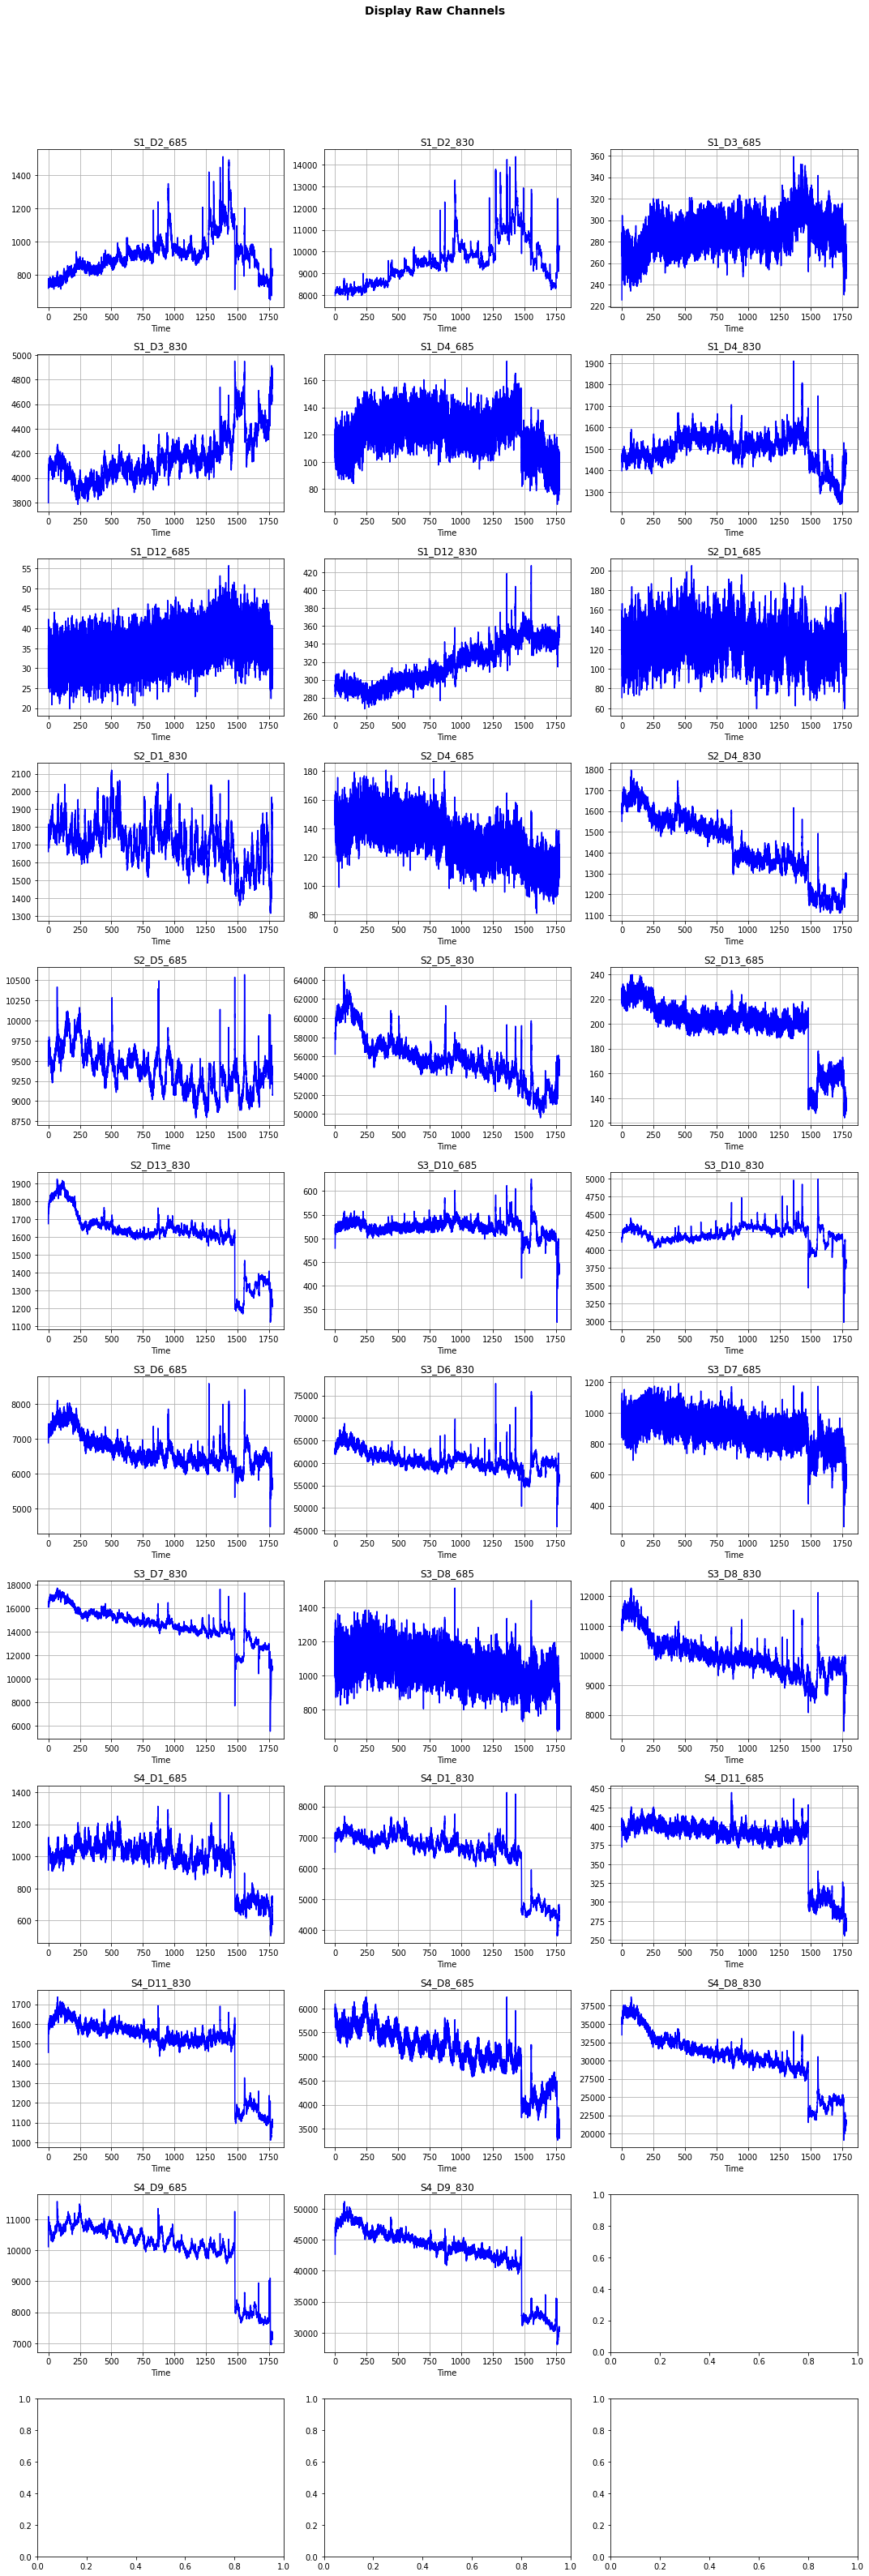

In [34]:
plotchannels(raw)

In [ ]:
df_filter(raw, cutoff=0.8, fs=30, order=5, title='Filtered Data')

In [ ]:
import matplotlib.cm as cm

def df_filter_and_stimulus(df, cutoff=0.8, fs=30, order=5, title='Filtered Data'): 

  nr_channels = len(df.columns)
  ncols= 1
  nrows= nr_channels

  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, sharey=False, figsize=(ncols*20,nrows*6))

  i = 0
  for c in df.drop(columns=['time']):
    # y_cutted = remove_outlier(df,c)[c]
    y_filtered = butter_lowpass_filter(df[c], cutoff=cutoff, fs=fs, order=order)

    # ax[i].plot(df.time, df[c], 'b-', label='raw data', alpha=0.4)
    ax[i].plot(df.time, y_filtered, 'r-', lw=1) # , label='filtered data')
    
    color = 0
    for s in stimulus.drop(columns=['time']):
      ax[i].vlines(stimulus.iloc[ stimulus[ stimulus[s] == 1 ][s].index ], y_filtered.min(), y_filtered.max(),label=s,lw=1, linestyle='dashed',
                   color=['r','k','m','g','c','y','b'][color])
      color = color + 1
      # print(stimulus[c])

    ax[i].set_title('Channel ' + str(c) + ', Filtered Data with Stimulus')
    ax[i].set_xlabel('Time')
    # ax[i].grid()
    ax[i].legend()

    i=i+1

  plt.suptitle(title, fontsize=14, weight='bold', y=1.05)

  plt.tight_layout()
  plt.show()

  return  

# df_filter_and_stimulus(raw[['time','S1_D1_685']], cutoff=0.8, fs=30, order=5, title='Filtered Data')  

In [ ]:
df_filter_and_stimulus(raw, cutoff=0.8, fs=30, order=5, title='Filtered Data')  

In [ ]:
stimulus.head()

In [ ]:
stimulus.iloc[ stimulus[ stimulus['MD'] == 1 ]['MD'].index ]


In [ ]:
for row in mat['s']:
  if row.sum() !=0:
    print(row)

In [ ]:
mat['CondNames'][0]

In [ ]:
mat['s'].sum()

In [ ]:
mat['t']

In [ ]:
mat['d'].shape

In [ ]:
mat['aux'][:,0]

In [ ]:
mat['brainsight']

In [ ]:
mat['brainsight'][0,0][list(mat['brainsight'][0].dtype.names).index('acquisitionDate')]

In [ ]:
mat['brainsight'][0].dtype.names

In [ ]:
print( mat['brainsight'][0,0][list(mat['brainsight'][0].dtype.names).index('parameters')] )

In [ ]:
mat['CondNames']

In [ ]:
mat['CondNames'].shape 

In [ ]:
mat['CondNames']

In [ ]:
mat['SD'][0].dtype

In [ ]:
a = mat['SD'][0].dtype 

In [ ]:
a.names

In [ ]:
mat['SD'][0,0][list(mat['SD'][0].dtype.names).index('MeasList')]

In [ ]:
mat['aux'][:,0]

In [ ]:
mat['brainsight'][0][0][1]

In [ ]:
!pip install colorama

In [ ]:
import os
import mne

from mne.io import read_raw_nirx, read_raw_snirf
from mne_nirs.io import write_raw_snirf
from numpy.testing import assert_allclose

In [ ]:
fnirs_data_folder = mne.datasets.fnirs_motor.data_path('/content/drive/MyDrive/fNIRS - análises compartilhadas/DATA_MotorNeuron')
fnirs_raw_dir = os.path.join(fnirs_data_folder, 'SUBJID_6082')
raw_intensity = read_raw_nirx(fnirs_raw_dir).load_data()

# Read `snirf` file

`nme-nirs` suporta dentre outros arquivos: 

```
read_raw_boxy
read_raw_brainvision
read_raw_nirx
read_raw_snirf
```

Mas não suporta arquivos `.nirs`. 



# **TO DO**

> * Verificar a possibilidade de empregar arquivos `read_raw_brainvision` diretamente
> * Verificar a possibilidade de conversão de arquivos dos diferentes formatos, em especial `read_raw_.nirs` $\leftrightarrow$ `read_raw_.snirf` $\leftrightarrow$  `read_raw_brainvision` 


In [ ]:
for method in dir(mne.io):
  if 'read_raw' in method:
    print(method)

## Read `.snirf` data

In [ ]:
file_in = '/content/drive/MyDrive/fNIRS - análises compartilhadas/DadosOutroGrupo/2019-02-14_001.snirf'
# file_in = '/content/drive/MyDrive/fNIRS - análises compartilhadas/BIDS-NIRS-Tapping-v0.0.1/rob-luke-BIDS-NIRS-Tapping-388d2cd/sub-01/nirs/sub-01_task-tapping_nirs.snirf'
# file_in = '/content/drive/MyDrive/fNIRS - análises compartilhadas/DATA_MotorNeuron/SUBJID_6082/run1.snirf'

# ValueError: sfreq must be positive
# file_in = '/content/drive/MyDrive/fNIRS - análises compartilhadas/5. Dados de Finger Tapping 2/ana.snirf' 

raw_intensity = mne.io.read_raw_snirf(file_in, verbose=True)

raw_intensity.load_data()

## Convert to Dataframe

Isso é útil para trabalhar com os dados de forma tabular.

In [ ]:
df = raw_intensity.to_data_frame()

In [ ]:
df.head()

## Inspeção inicial dos Dados

In [ ]:
print('\nNúmero de Canais:'.ljust(35), df.shape[1] - 1)

max_measure = df.iloc[0::,1::].max().max()
min_measure = df.iloc[0::,1::].min().min()
print('\nIntervalo das medidas:'.ljust(35), min_measure, max_measure)

print('\nCanais por prefixo (source):'.ljust(35))
list_prefix_channels = [x[0:x.find('_')] for x in df.columns[1::]]
summary_prefix_channels = {}
summary_prefix_channels_list = {}
for c in list_prefix_channels:
  if c not in summary_prefix_channels.keys():  
    summary_prefix_channels[c] = list_prefix_channels.count(c)
    summary_prefix_channels_list[c] = [x for x in df.columns[1::] if c+'_' in x]

for c in summary_prefix_channels.keys():  
    print(34*' ',c, summary_prefix_channels[c], '\t', summary_prefix_channels_list[c])

print('\nCanais por sufixo (wave length):'.ljust(30))
list_suffix_channels = [x[x.find(' ')+1::] for x in df.columns[1::]]
summary_suffix_channels = {}
for c in list_suffix_channels:
  if c not in summary_suffix_channels.keys():  
    summary_suffix_channels[c] = list_suffix_channels.count(c)
    print(34*' ',c, summary_suffix_channels[c])
  
print('\nTimes:'.ljust(35), df.shape[0])

print('\nElapse times:'.ljust(30))
for i in range(len(df.time.diff()[1::].value_counts())):
  print(34*' ', df.time.diff()[1::].value_counts().index[i], df.time.diff()[1::].value_counts().values[i])



In [ ]:
for s in summary_prefix_channels.keys(): 
  fig, ax = plt.subplots(nrows=1, ncols=8, sharex=True, sharey=True,figsize=(24,3))
  i = 0
  for c in summary_prefix_channels_list[s]:
    ax[i].plot(df.index, df[c])
    ax[i].set_title(c, fontsize=16, weight='bold')
    i = i + 1
    plt.xticks([])
    plt.ylim([min_measure, max_measure])

    if i >= 8: 
      print('Warning: Há mais de 8 detectores para a mesma fonte')
      break
 
  plt.tight_layout()
  plt.show()


In [ ]:
colunas = 4
linhas = int( len( summary_prefix_channels.keys() ) / colunas )

fig, ax = plt.subplots(nrows=linhas, ncols=colunas, sharex=True, sharey=True,figsize=(4*linhas,4*colunas))
i = 0
for s in summary_prefix_channels.keys(): 
  for c in summary_prefix_channels_list[s]:
    ax[i//colunas, i%colunas].plot(df.index, df[c], label=c)
  ax[i//colunas, i%colunas].set_title(s, fontsize=16, weight='bold')
  ax[i//colunas, i%colunas].legend(fontsize=8)
  plt.xticks([])
  plt.ylim([min_measure, max_measure])
  i = i + 1 
  
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(16,12))

i = 0
for s in summary_prefix_channels.keys(): 
  for c in summary_prefix_channels_list[s]:
    ax[0].boxplot(df[c], positions=[i])
    ax[1].boxplot(df[c] / df[c].max(), positions=[i])
    ax[2].boxplot(( df[c] - df[c].mean() ) / df[c].std(), positions=[i])
    i = i + 1

ax[0].set_title('Absolute Values',fontsize=14,weight='bold')    
ax[1].set_title('Normalized Values',fontsize=14,weight='bold') 
ax[2].set_title('z-Score Values',fontsize=14,weight='bold') 

ax[2].set_xticks(ticks=np.arange(0,96))
ax[2].set_xticklabels(labels=df.columns[1::],rotation=60,fontsize=7)

plt.tight_layout()
plt.show()

In [ ]:
s = input('Entre com um conjunto de canais ou enter para o primeiro conjunto: ')
if s == '': s = list( summary_prefix_channels.keys() )[0]

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(16,4))

i = 0
for c in summary_prefix_channels_list[s]:
  ax[0].plot(df.index, df[c] , label=c)
  ax[1].plot(df.index, ( df[c] - df[c].mean() ) / df[c].std() + i*2, label=c)
  i = i + 1

ax[0].set_title(s + ' raw signals', fontsize=16, weight='bold')
ax[0].legend(fontsize=8)

ax[1].set_title(s + ' z-score + i', fontsize=16, weight='bold')
ax[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

# Obtendo os eventos

In [ ]:
for i in range(len(raw_intensity.annotations)):
  print(raw_intensity.annotations[i])

In [ ]:
events = {}
for a in raw_intensity.annotations:
  if a['description'] not in events.keys():
    events[a['description']] = []
  events[a['description']].append(a['onset'])  

events

In [ ]:
plt.figure(figsize=(16,4))

s = input('Entre com um conjunto de canais ou enter para o primeiro conjunto: ')
if s == '': s = list( summary_prefix_channels.keys() )[0]

for c in summary_prefix_channels_list[s]:
  plt.plot(df.index, df[c], label=c)
plt.title(s, fontsize=16, weight='bold')
plt.legend(fontsize=8)

# print(plt.gca().get_ylim()) # min and max values in y axis
lim = plt.gca().get_ylim()
colors = 'brgcmyk' # até 7 diferentes eventos

i = 0
for e, t_list in events.items():
  i = i + 1
  for t in t_list:
    plt.vlines(t*10,lim[0],lim[1],colors=colors[i-1],linestyles='dotted')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(16,4))

c = input('Entre com um canais ou enter para o primeiro canal: ')
if c == '': c = df.columns[1] 

plt.plot(df.index, df[c])
plt.title(c, fontsize=16, weight='bold')

# print(plt.gca().get_ylim()) # min and max values in y axis
lim = plt.gca().get_ylim()
colors = 'brgcmyk' # até 7 diferentes eventos

i = 0
for e, t_list in events.items():
  i = i + 1
  for t in t_list:
    plt.vlines(t*10,lim[0],lim[1],colors=colors[i-1],linestyles='dotted')

plt.tight_layout()
plt.show()

In [ ]:
# raw_intensity.ch_names

In [ ]:
# raw_intensity.get_channel_types()